# Toy Data Example 1

In this example we will generate some synthetic multidimensional time series data and then run the kernel change-point detection (kcp_ds) and visualization (kcp_v) Python functions on it.

In [1]:
from typing import List, Tuple
import random

import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy.stats import gaussian_kde

# import sys; sys.path.insert(0, "..")
from kcpdi.kcp_ds import kcp_ds
from kcpdi.kcp_v import kcp_v

# Toy example

In order to run the functions, it is necessary to have a numpy array containing the data we wish to feed to the functions. This array must be of dimension (number of time points) __x__ (number of parallel time series). 

This therefore supposes that the data you wish to work with is either already in this form (same time points for all time series) or than you have taken raw data (perhaps with differing time points for different time series) and interpolated it to a fixed time grid. 

For real datasets, some of the following steps will also probably need to be taken before running the functions:

1) Removing or imputing missing data. The functions assume that there is no missing data or non-numeric values.

2) Normalizing the data in some way. If some time series have much larger numerical ranges than others, then their changes and anomalies will have an outsized effect on the function outputs. This may be what you expect, so in that case, you do not necessarily have to do any normalization. But if you want the functions to more-or-less treat all time series equally, it might be a good idea to individually normalize each time series to have mean 0 and variance 1, or perform some other normalization (e.g., an affine map so that each time series has a minimum of 0 and a maximum of 1. 


## Generate time series data

The code block below generates __num_columns__ time series with __num_rows__ time points each (the same ones). It generates N(0,1) random Gaussian data and adds it to the running value of the mean. At each new time point there is a probability of __mean_jump_probability__ that there will be a jump in the mean to a new mean, and so on until the end of the __num_rows__ time points.

To spice things up, we propose that there are __num_peak_rows__ special time points at which it is __much more likely that there is a change-point__ for each time series. In the code below, it is a 50x more likely for there to be a change-point in the mean at five randomly chosen times. 

In [2]:
def generate_random_data_with_random_peaks(
    num_rows: int,
    num_columns: int,
    mean_jump_probability: float = 0.005,
    num_peak_rows: int = 5,
) -> Tuple[np.array, List[List[int]], List[int]]:
    """Generate a NumPy array with Gaussian data and random jumps in
    mean at specified peak rows.

    Args:
        num_rows: Number of rows (time points).
        num_columns: Number of columns (time series).
        mean_jump_probability: Base probability of a mean jump occurring
            in a column.
        num_peak_rows: Number of peak rows with increased jump
            probability.

    Returns:
        The generated NumPy array.
        The list of jump positions for each column.
        The row indices of the peak rows.
    """
    
    if (num_peak_rows >= num_rows):
        num_peak_rows = num_rows-1
        print("The variable num_peak_rows was greater than or equal to num_rows, we have reduced it to size num_rows-1")
        
    
    data = np.empty((num_rows, num_columns))
    jump_positions = [[] for _ in range(num_columns)]

    # Randomly select row indices for peak rows
    peak_rows = random.sample(range(num_rows), num_peak_rows)

    for col in range(num_columns):
        mean = 0  # Initialize mean for this column
        for row in range(num_rows):
            if row in peak_rows:
                jump_prob = mean_jump_probability * 50  # Higher probability at peak rows
            else:
                jump_prob = mean_jump_probability

            if random.random() < jump_prob:
                # Randomly jump the mean
                jump = random.uniform(-5, 5)
                mean += jump
                jump_positions[col].append((row, jump))

            data[row, col] = mean + np.random.normal(0, 1)  # Generate Gaussian data with the current mean

        # Normalize the column to have mean 0 and variance 1
        data[:, col] = (data[:, col] - np.mean(data[:, col])) / (1*(np.std(data[:, col])==0) + np.std(data[:, col]))

    return data, jump_positions, peak_rows

In [3]:
num_rows = 1000  # Number of time points
num_columns = 100  # Number of time series
mean_jump_probability = 0.005  # Base jump probability
num_peak_rows = 5  # Number of peak rows

# Call the function to generate random data with random peak rows
random_data, jump_positions, peak_rows = generate_random_data_with_random_peaks(
    num_rows, num_columns, mean_jump_probability, num_peak_rows
)

## Plot the generated data for a subset of the time series

The function below will plot at most 20 generated time series. It will output these plots of the data along with vertical red lines showing where each time series's changes in mean were.

In [4]:
def plot_data_in_subplots_with_lines_limited(
    data: np.array,
    jump_positions: List[List[int]],
    title: str = "Random Data with Jumps",
) -> None:
    """Plot the generated data for each column in separate subplots with
    vertical red lines at jump positions.
    
    Limit the number of subplots displayed to at most 20 if there are
    more columns.

    Args:
        data: The generated data as a NumPy array.
        jump_positions: List of jump positions for each column.
        title: Title of the overall plot.
    """
    num_columns = data.shape[1]
    
    if num_columns > 20:
        # If there are more than 20 columns, limit to the first 20
        num_columns = 20

    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 2 * num_columns), sharex=True, sharey=True)
    fig.suptitle(title)
    
    if num_columns == 1:
        plt.plot(data[:,0])
        positions = jump_positions[0]
        for position in positions:
            row, _ = position
            plt.axvline(x=row, color='red', linestyle='--', label="Jump")
            plt.xlabel("Time Points")
            plt.ylabel("Values")
        
    else:    
        for col, ax in enumerate(axes):
            ax.plot(data[:, col], label=f"Column {col}")
            positions = jump_positions[col]
            for position in positions:
                row, _ = position
                ax.axvline(x=row, color='red', linestyle='--', label="Jump")

            ax.set_xlabel("Time Points")
            ax.set_ylabel("Values")
            #ax.legend()
            ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Run the plotting function

Now run the above plotting function.

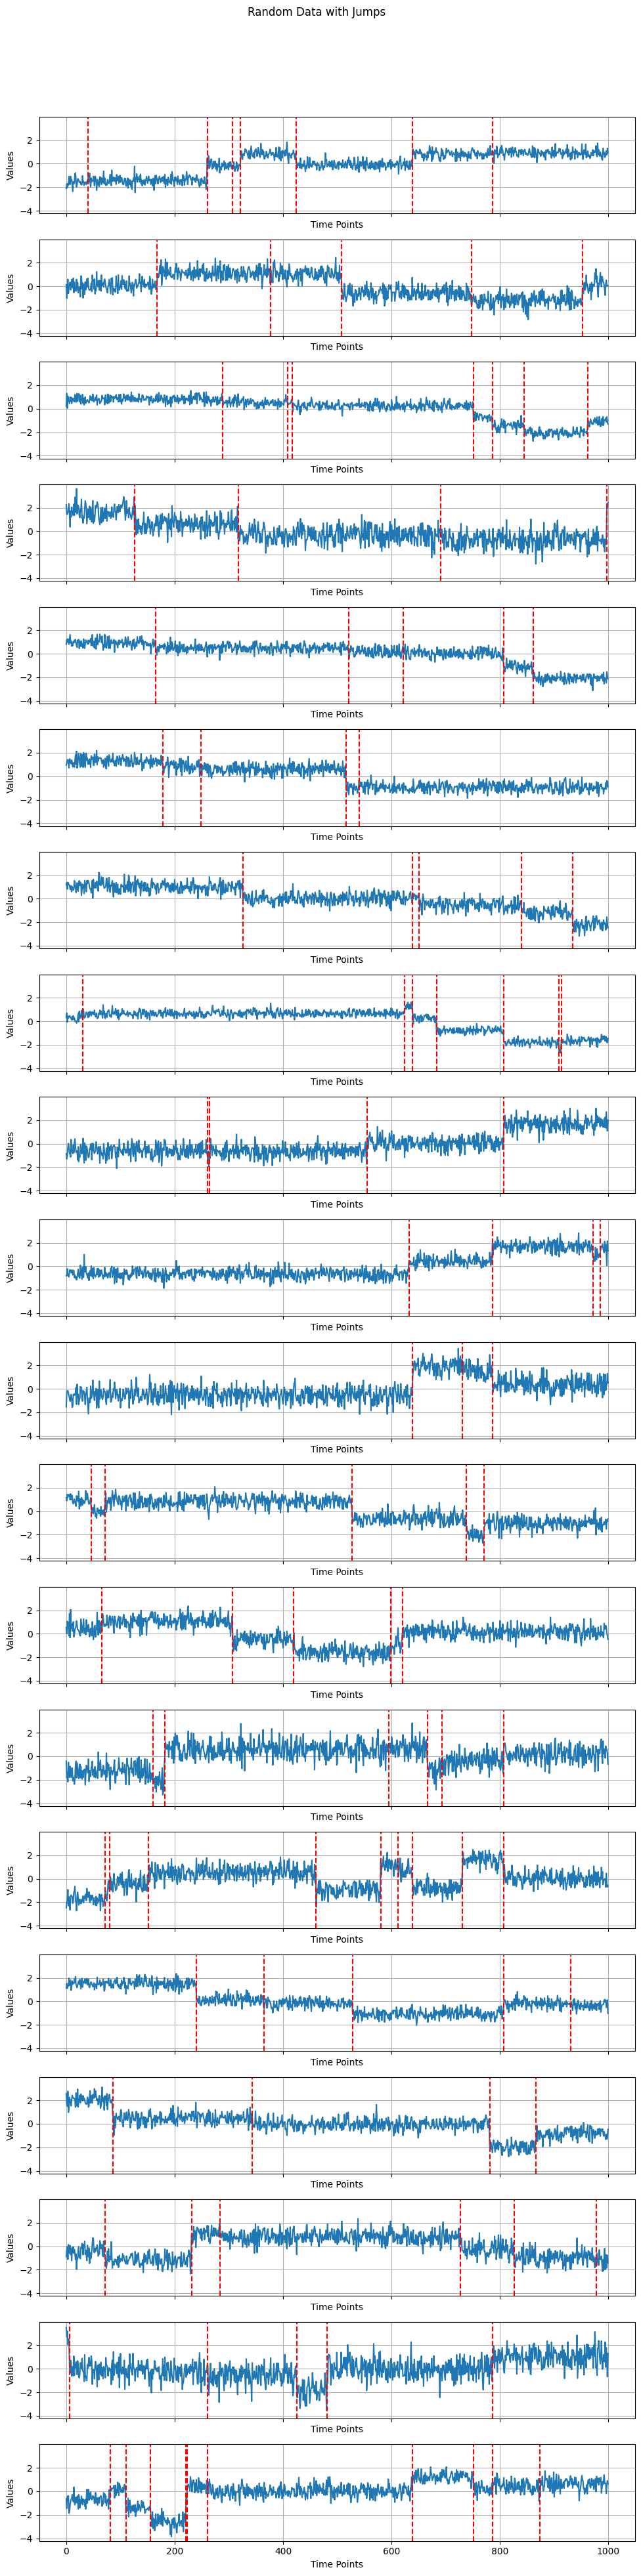

In [5]:
# Usage:
# Assuming you have already generated random_data and jump_positions
plot_data_in_subplots_with_lines_limited(random_data, jump_positions)

## Histogram and kernel smoothing of true change-point locations

For a sanity check, we can plot the distribution of change-point locations across the whole dataset and check that there are indeed some hotspots where many more individual time series had changes.

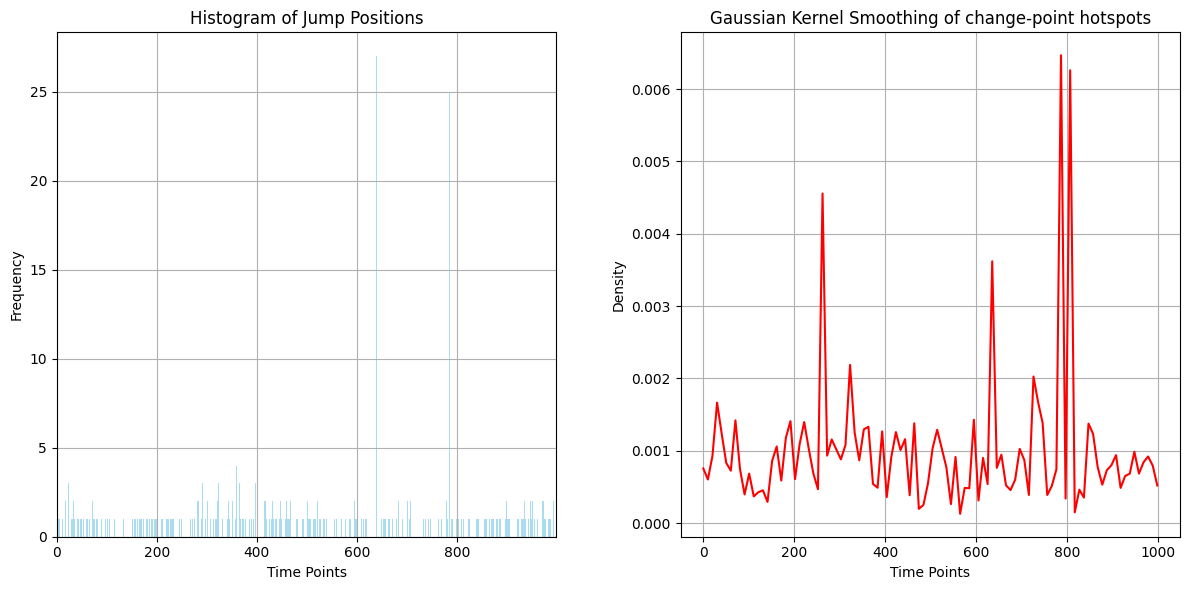

In [6]:
# Assuming you have generated data and jump_positions using generate_random_data_with_jumps
combined_jump_positions = [position for positions in jump_positions for position in positions]

# Extract the row positions where jumps occurred
jump_row_positions = [position[0] for position in combined_jump_positions]

# Create a histogram to show where the jump positions were mostly located
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a subplot on the left

hist, bins, _ = plt.hist(jump_row_positions, bins=num_rows, color='skyblue', alpha=0.7)
plt.title("Histogram of Jump Positions")
plt.xlabel("Time Points")
plt.ylabel("Frequency")
plt.xlim(0,num_rows-1)
plt.grid(True)

# Perform Gaussian kernel density smoothing of the histogram
plt.subplot(1, 2, 2)  # Create a subplot on the right

# Create a Gaussian kernel density estimate
if len(jump_row_positions) > 1:
    my_bandwidth = .01
    kde = gaussian_kde(jump_row_positions,bw_method=my_bandwidth)
    
    x = np.linspace(0, num_rows-1, 100)
    pdf = kde(x)

    plt.plot(x, pdf, color='red', label='Gaussian Kernel Smoothing')
    plt.title("Gaussian Kernel Smoothing of change-point hotspots")
    plt.xlabel("Time Points")
    plt.ylabel("Density")
    plt.grid(True)

else:
    plt.plot(range(num_rows),[i*0 for i in range(num_rows)], color='red', label='Gaussian Kernel Smoothing')
    plt.title("Gaussian Kernel Smoothing of change-point hotspots")
    plt.xlabel("Time Points")
    plt.ylabel("Density")
    plt.grid(True)

plt.tight_layout(w_pad=4)
plt.show()

It will probably be clearest on the Gaussian kernel smoothing subplot (right) that there are a few hotspots where more change-points were located on average. Let us look at where these hotspots were actually located:

In [7]:
print('The randomly generated change-point hotspot times were: ', np.sort(peak_rows))

The randomly generated change-point hotspot times were:  [260 639 731 786 807]


## Run the kernel change-point detection algorithm

We are now ready to run the kernel change-point detection algorithm on the generated __data__ above.

In [8]:
my_data = random_data

detected_change_points, interval_end_points = kcp_ds(my_data, expected_frac_anomaly=15/1000)

print('The detected change-points are at times: ', detected_change_points)

The detected change-points are at times:  [157, 260, 397, 516, 639, 731, 807, 900]


## Remarks

If you have come this far without changing any of the code, you will likely see that there are more detected change-points than there are hotspots, but that most likely the hotspots correspond to detected change-points (give or take one or two time steps to the left or right).

This is normal because there are indeed other time spots at which, by chance, there were also more change-points than average randomly generated. If you take the detected change-points that are not in __peak_rows__, they most likely correspond to high density spots in the above Gaussian kernel density plot too. 

(<Figure size 1000x2000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

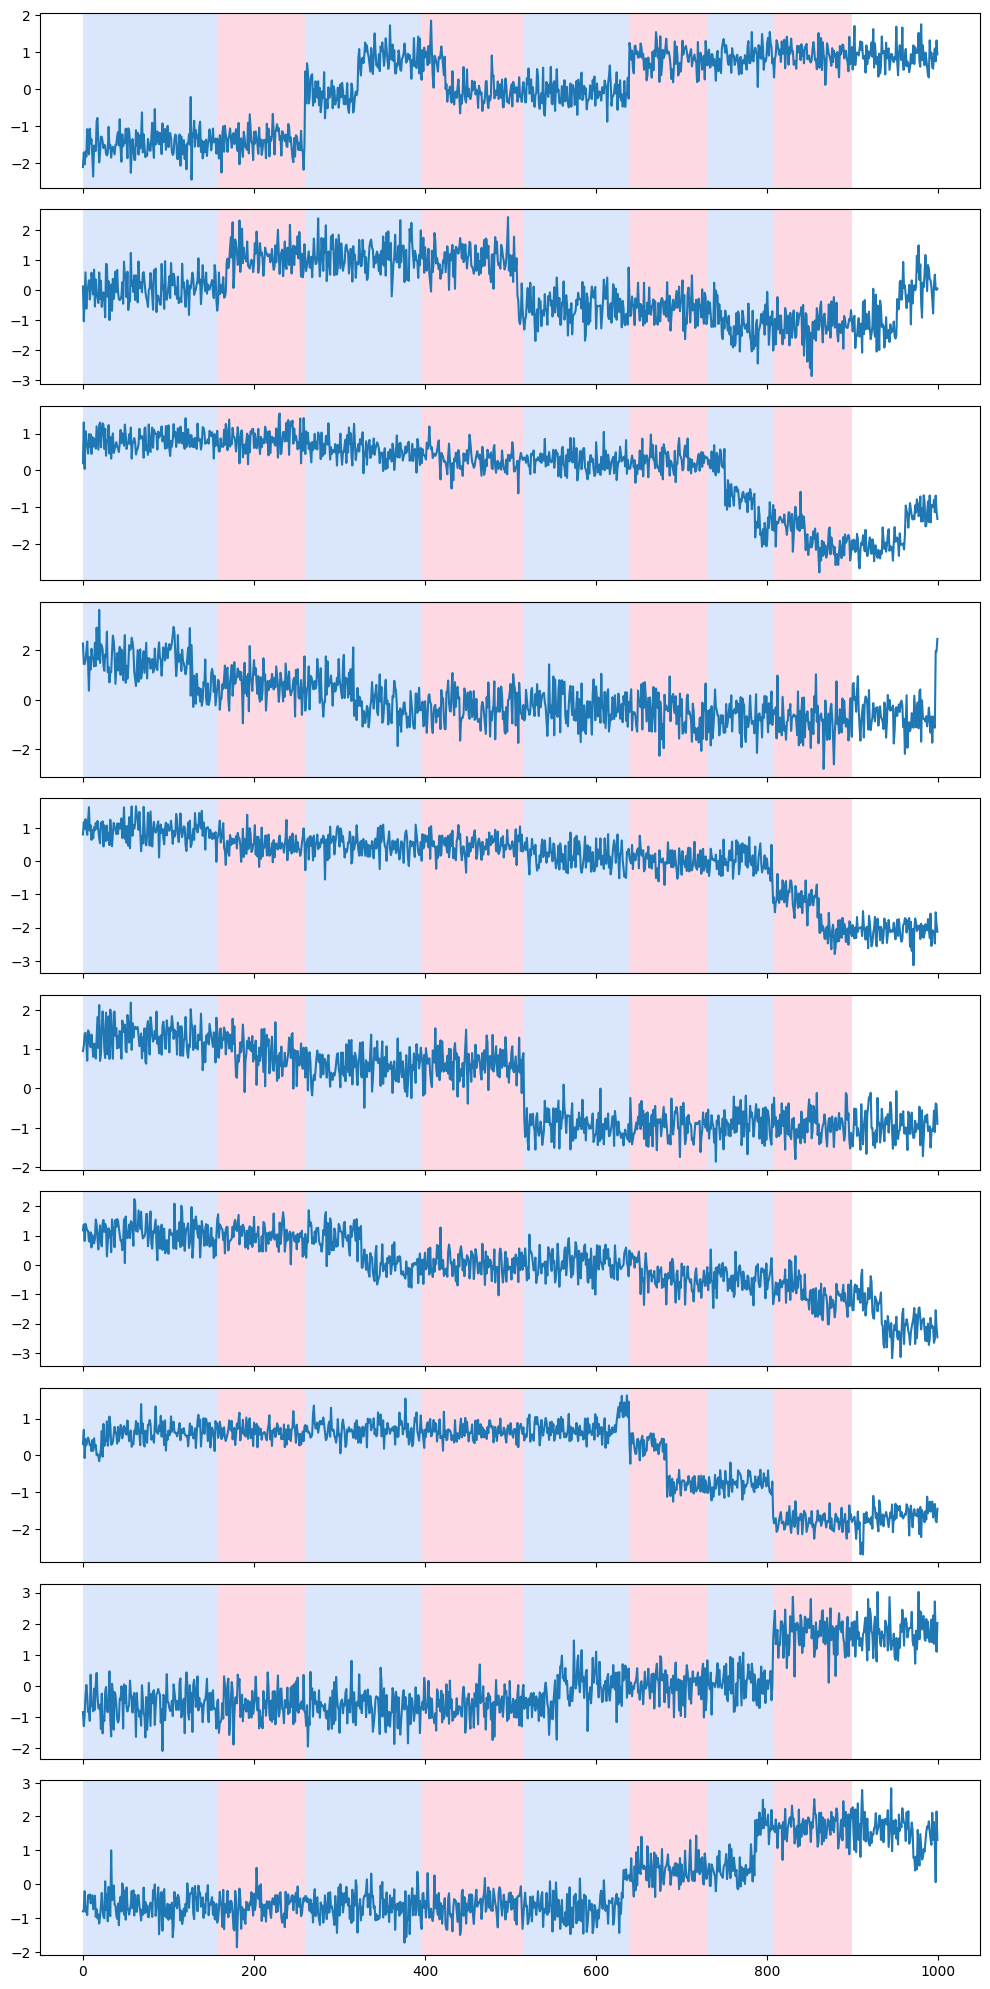

In [9]:
rpt.display(my_data[:, 0:min(10, np.shape(my_data)[1])], detected_change_points)

## Visualizing the contribution of individual time series to the detection of a change-point

The following code block goes through the detected change-points, one by one, and tries to tease out which of the individual time series were responsible (i.e., explain) the detection of the change-point.

Below, we plot the overall linear kernel change-point detection criterion (in blue) recalculated between:
- left boundary: either the previous change-point or else time point 0 if we are looking at the first change-point
- right boundary: either the next change-point, the end-point of the data, or, if the number of time points was large, possible the right boundary is some time point __before__ the next change-point (or end point). This latter possibility may occur when the number of data points is greater than __max_n_time_points__, an input into the kcp_ds function, since the underlying code requires stocking a matrix of size max_n_time_points x max_n_time_points, so max_n_time_points is chosen so as not to crash the memory capacity you are working with on your particular PC or server. 


It turns out that when you restrict the criterion to be recalculated over such intervals, it automatically has its minimum at the previously detected change-point. And since we are working with the linear kernel, it turns out that the criterion value at each time is equal to the __sum__ of the criteria for each of the individual time series, when calculated __alone__ ! 

This is what we see in the plot below: a blue line corresponding to the global criterion (where its minimum is the change-point location), and several other colored lines corresponding to the __n_legend__ individual time series whose criterion was the __lowest__ at the shared change-point time (the time point at the minimum of the blue line).

All of the other individual time series criteria are drawn in black in order to simplify interpretation of the more important (colored) ones.

__Remarks__

1) Note that to get into the list of the top __n_legend__ time series, you do not necessarily have to have your minimum at the same place as the global minimum. What you __do__ need to do is to have one of the __n_legend__ smallest values at the time corresponding to the global minimum.

2) A consequence of this is that an individual time series would have actually placed a change-point elsewhere in the interval if only its personal criterion was used, but __since it still has a low value__ at the global minimum, it still had a partial influence on the location of the global minimum. 

3) This kind of information could get lost if you are looking at numerical outputs and ordered lists of importance, but __is very clear__ when you use these kinds of plots. 

Change point number 1 



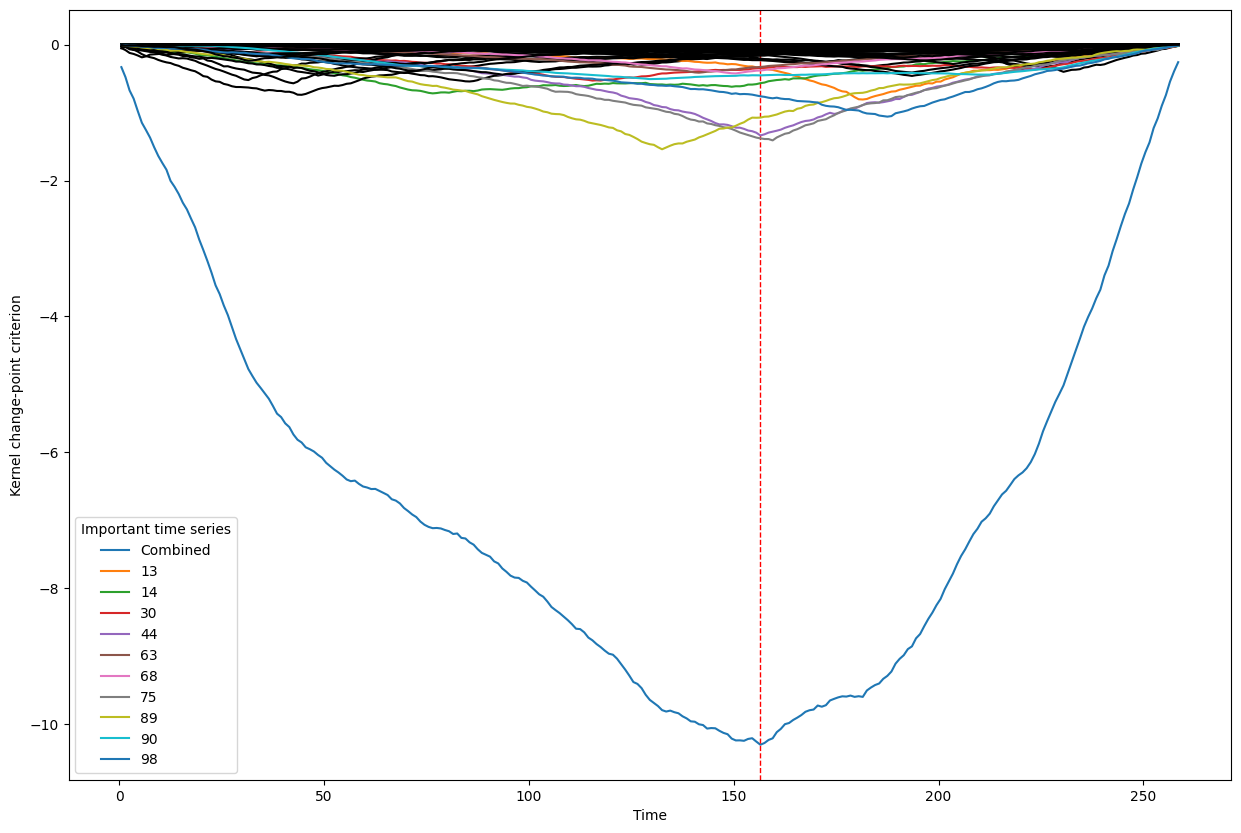

Change point number 2 



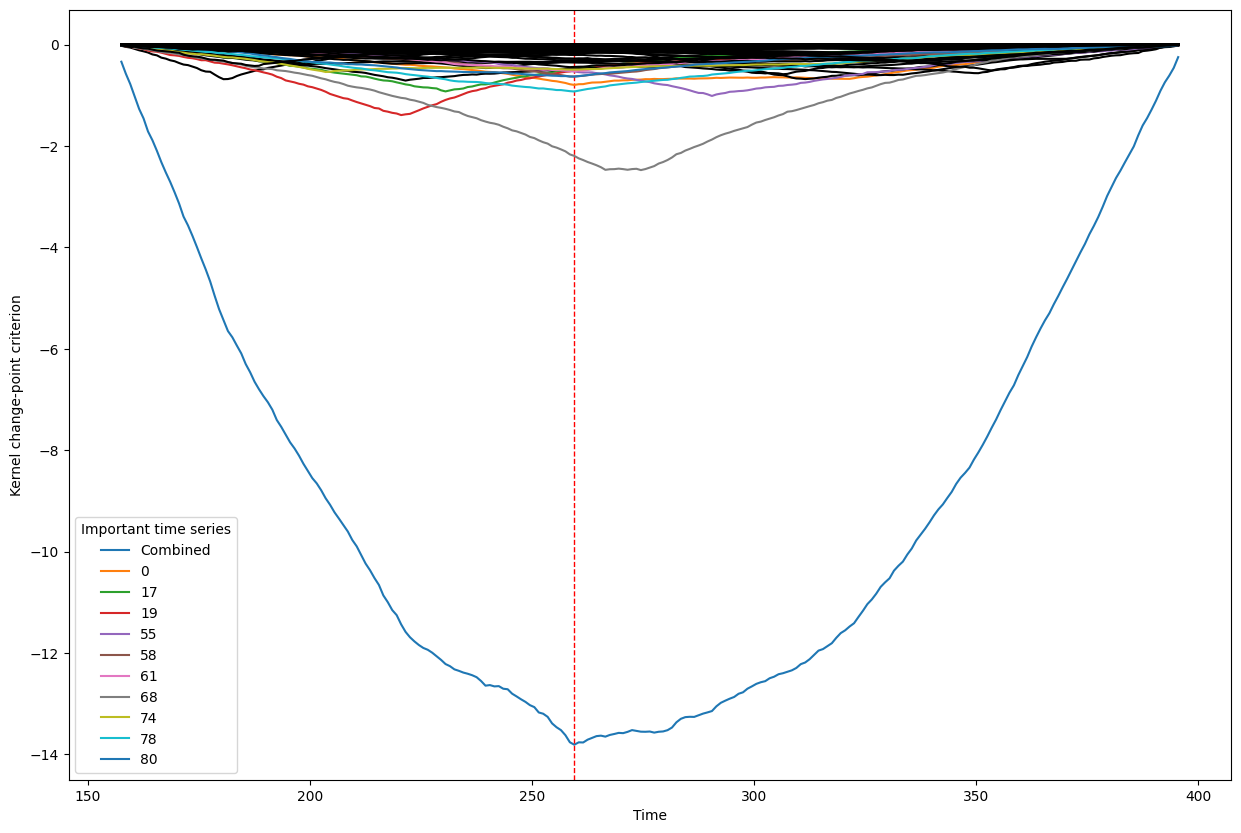

Change point number 3 



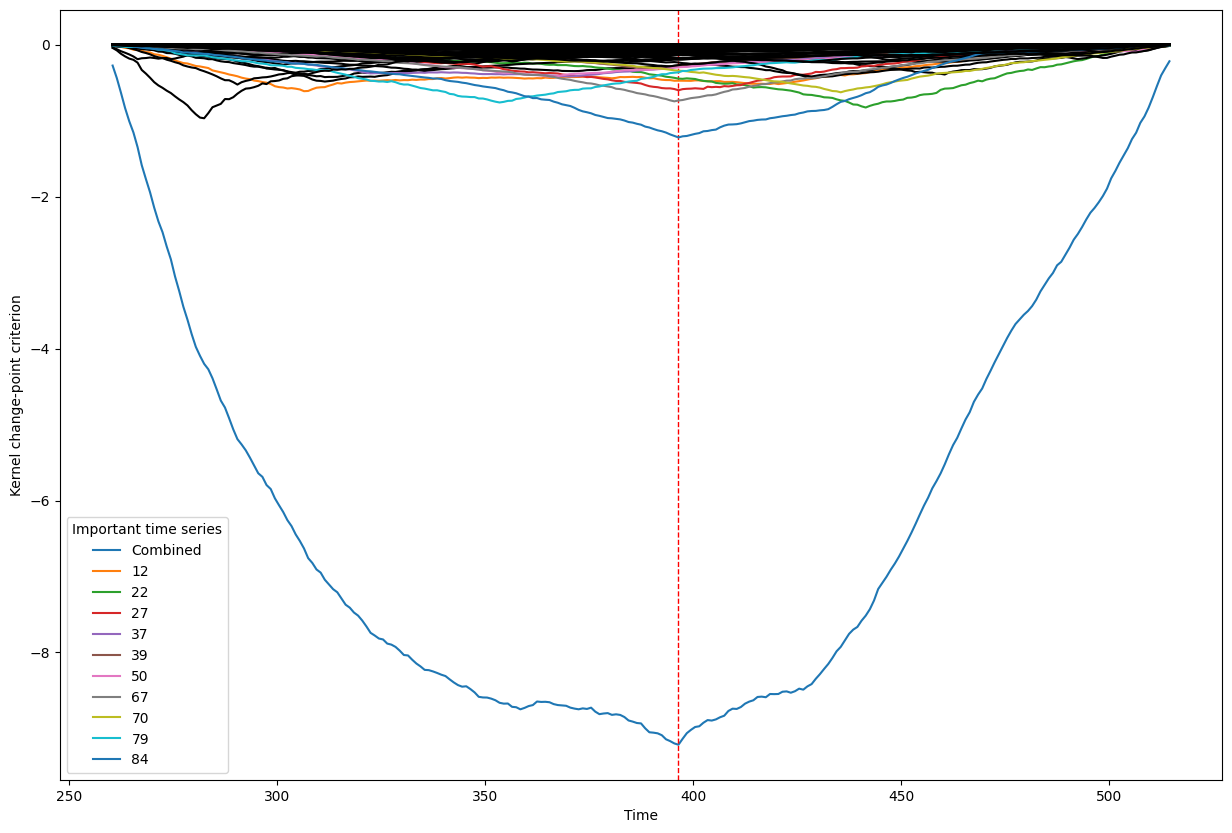

Change point number 4 



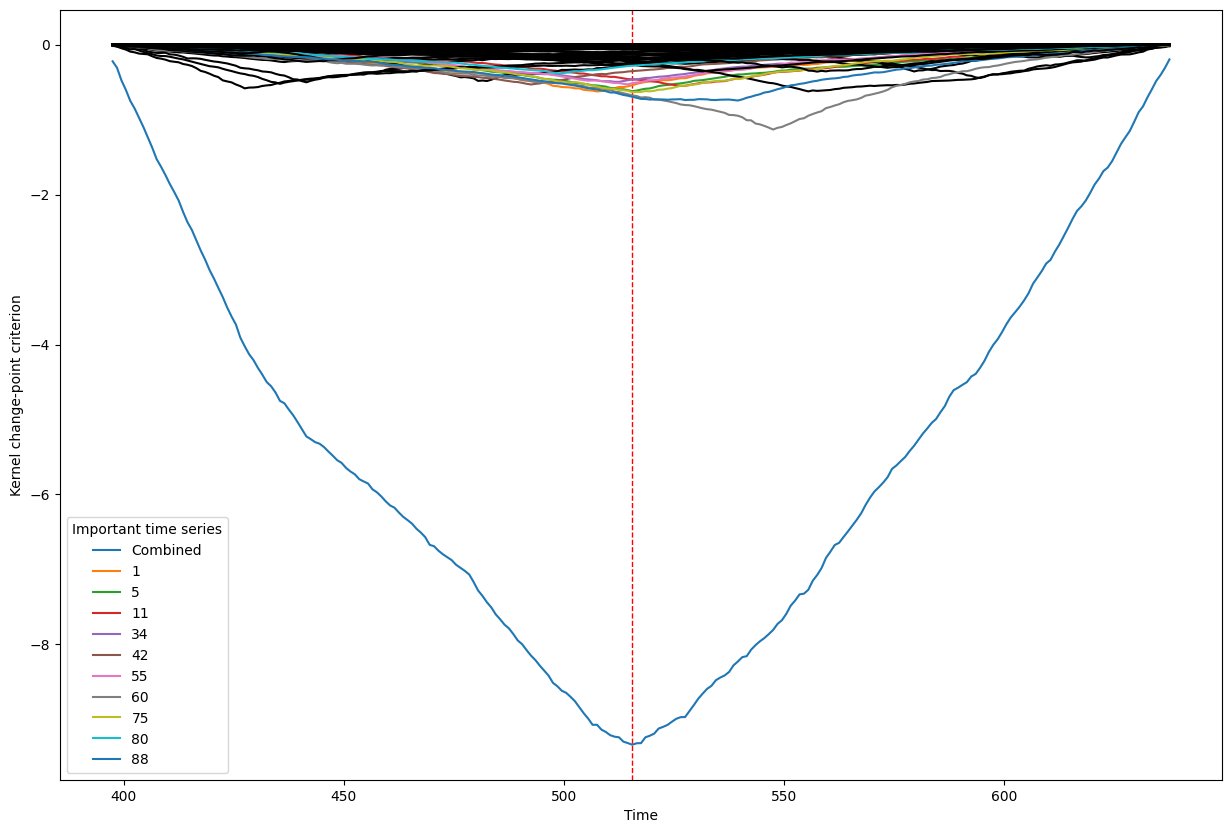

Change point number 5 



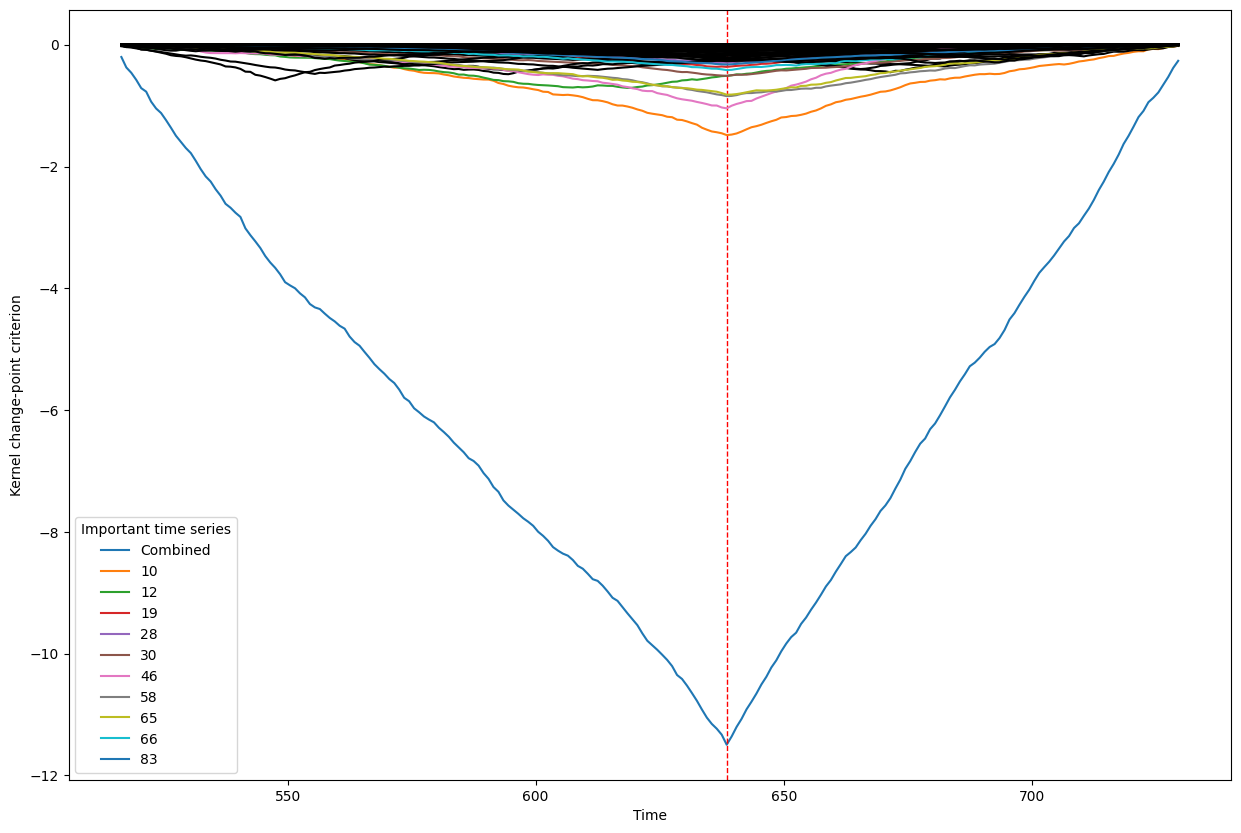

Change point number 6 



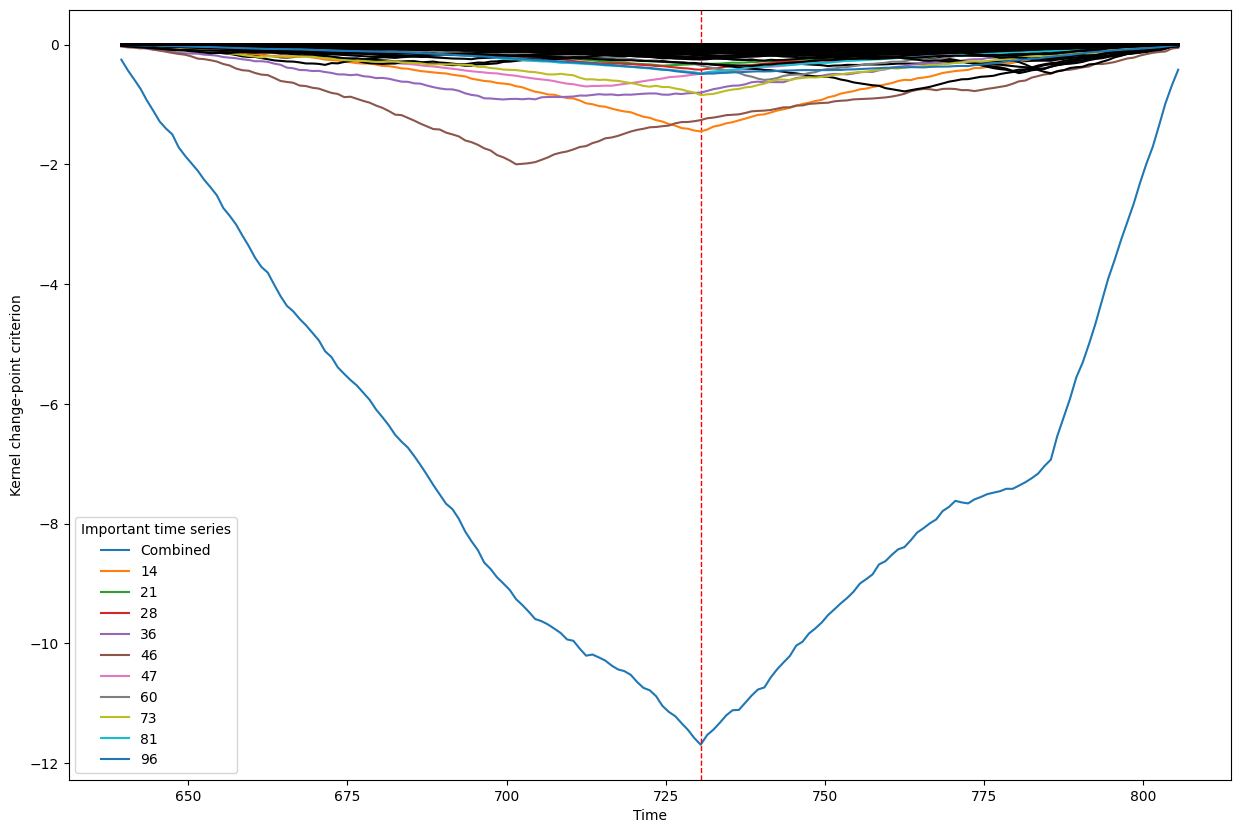

Change point number 7 



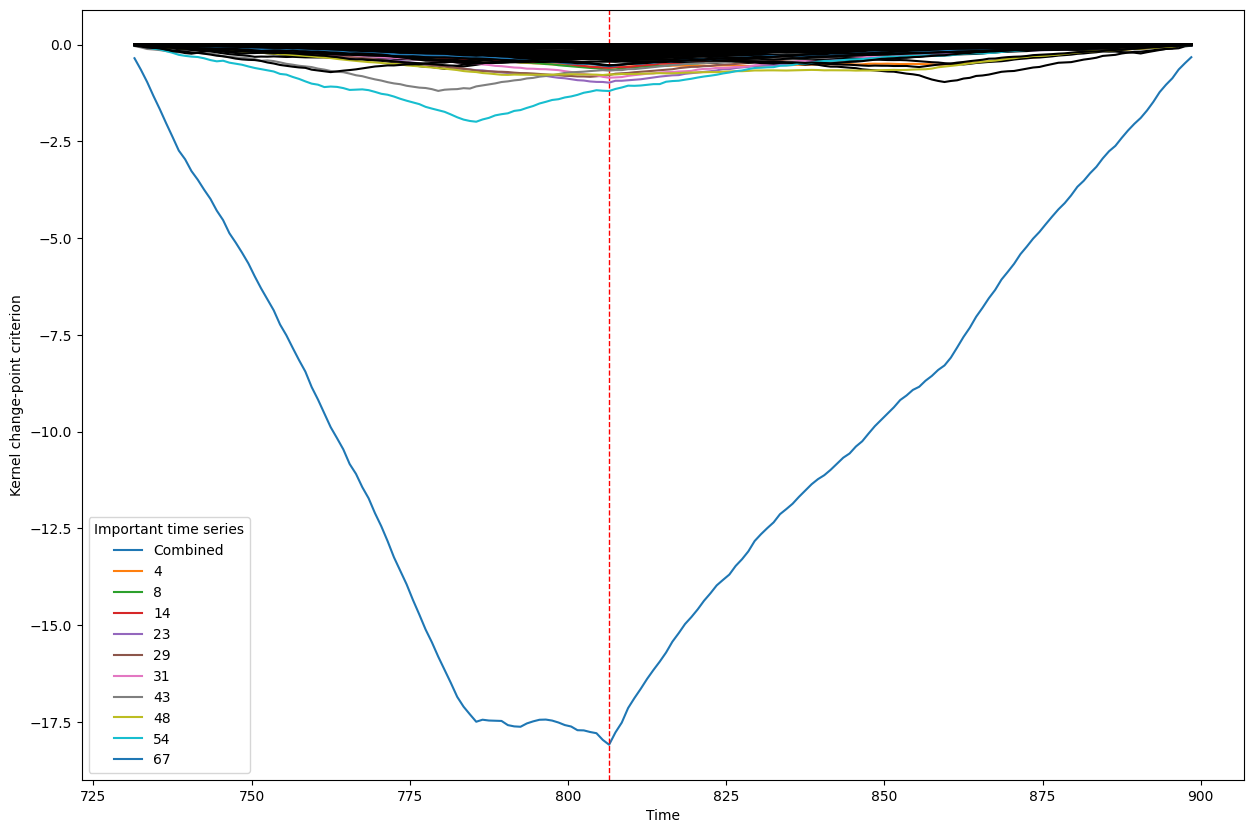

Change point number 8 



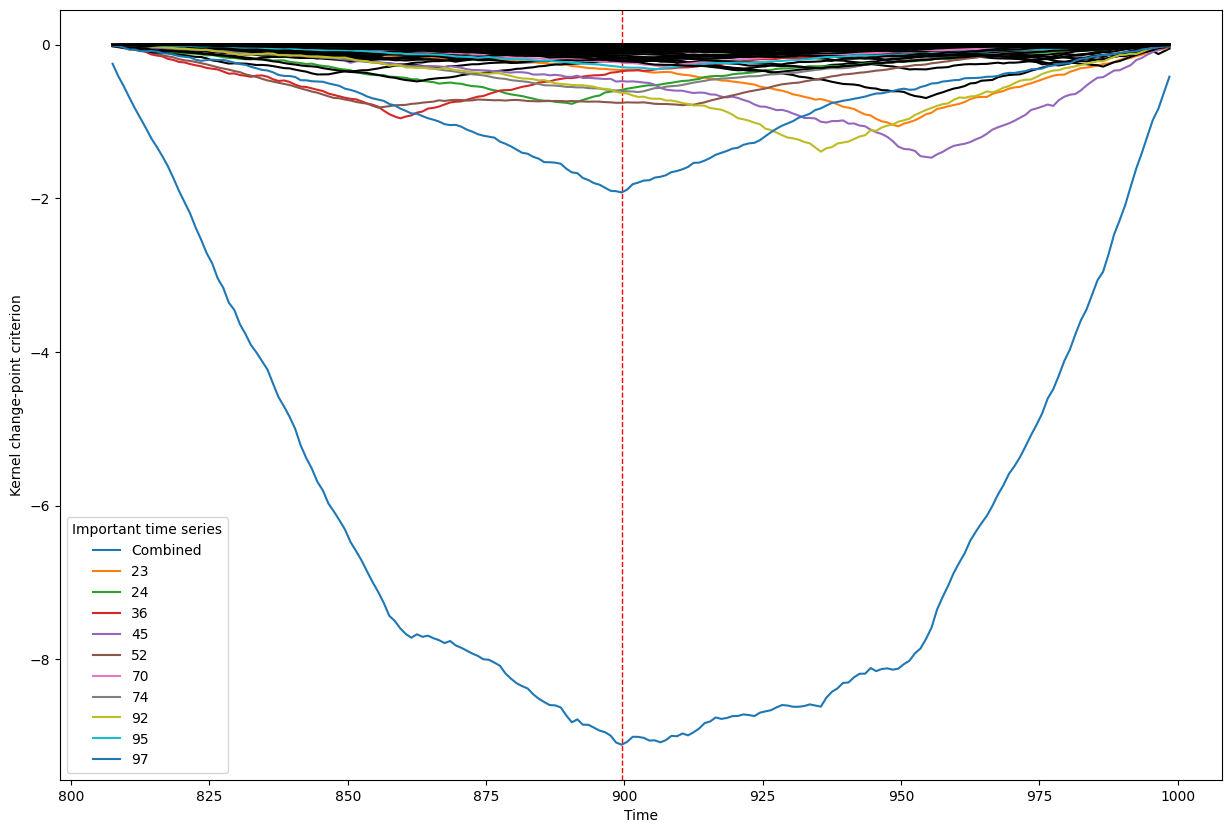

In [10]:
true_times = range(0,np.shape(my_data)[0])

kcp_v(my_data, true_times, detected_change_points, interval_end_points)